# Import Module

In [ ]:
import os
import math

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
import seaborn as sns 
import tensorflow.keras.applications.efficientnet as backbone

from tensorflow.keras.callbacks import TensorBoard

tensorflow version: 2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o '/content/drive/Shareddrives/Casting_data/casting_data.zip' -d '/Data'

Archive:  /content/drive/Shareddrives/Casting_data/casting_data.zip
   creating: /Data/casting_data/test/
   creating: /Data/casting_data/test/def_front/
  inflating: /Data/casting_data/test/def_front/cast_def_0_1059.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1063.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_108.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1096.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_112.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1134.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1136.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1137.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1153.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1171.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1172.jpeg  
  inflating: /Data/casting_data/test/def_front/cast_def_0_1174.jpeg  
  inflat

# Constants

In [ ]:
LOG_DIR = '/content/drive/Shareddrives/Casting_data/Backbone Testing/Default Augmentation/TensorBoard-Casting/'

train_path = '/Data/casting_data/train/'
test_path = '/Data/casting_data/test/'

myfile = 'EffNetB4'

img_size = (512, 512)
n_epochs = 10
train_batch_size = 4
validation_split = 0.2

input_width = img_size[0] 
input_height = img_size[1] 

# TensorBoard

In [ ]:
def get_TensorBoard(filename):
    dir_paths = os.path.join(LOG_DIR,filename)
    
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')

    return TensorBoard(log_dir=dir_paths)

# Preprocessing

In [ ]:
from tensorflow.python.ops import gen_image_ops
tf.random.set_seed(404)

# @tf.function()
# def random_hue(img, max_delta, seed=404):
#     delta = tf.random.uniform([], -max_delta, max_delta, seed=seed)
#     rgb_altered = gen_image_ops.adjust_hue(img, delta)
#     return rgb_altered

# @tf.function()
# def random_contrast(img, lower, upper, seed=404):
#     contrast_factor = tf.random.uniform([], lower, upper, seed=seed)
#     adjusted = gen_image_ops.adjust_contrastv2(
#         img, contrast_factor=contrast_factor)
#     return adjusted

# @tf.function()
# def random_mask(img, threshold=0.99, mask_value=0.):
#     noise = tf.random.normal(img.shape)
#     img = tf.where(noise >= threshold, 1., img)
#     img = tf.where(noise <= 1.-threshold, 1., img)
#     return img

# cannot invert, pretrained support RGB only
# @tf.function()
def preprocess_train(img):
    img = tf.image.random_hue(img, max_delta=0.5, seed=404)
    img = tf.image.random_contrast(img, lower=0.75, upper=1.5, seed=404)
#     img = tf.image.random_crop(img, size=(input_height, input_width, 3))
    img = tf.clip_by_value(img, 0., 255.)
    img = backbone.preprocess_input(img)
    return img

imageGenerator = ImageDataGenerator(
    # rotation_range=45,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    shear_range=5, 
    zoom_range=0.1,
    fill_mode='constant',
    horizontal_flip=True, 
    vertical_flip=True,
    dtype=tf.float32,
    validation_split=validation_split,
    preprocessing_function=preprocess_train)

In [ ]:
tf.random.set_seed(404)
train_gen = imageGenerator.flow_from_directory(
    train_path,
    target_size=(input_height, input_width),
    classes=["def_front", "ok_front"],
    class_mode="binary",
    batch_size=train_batch_size,
    subset="training",
    seed=404
)

val_gen = imageGenerator.flow_from_directory(
    train_path,
    target_size=(input_height, input_width),
    classes=["def_front", "ok_front"],
    class_mode="binary",
    batch_size=train_batch_size,
    subset="validation",
    seed=404
)

test_gen = ImageDataGenerator(dtype=tf.float32, preprocessing_function=backbone.preprocess_input).flow_from_directory(
    test_path,
    target_size=(input_height, input_width),
    classes=["def_front", "ok_front"],
    class_mode="binary",
    batch_size=1,
    seed=404
)

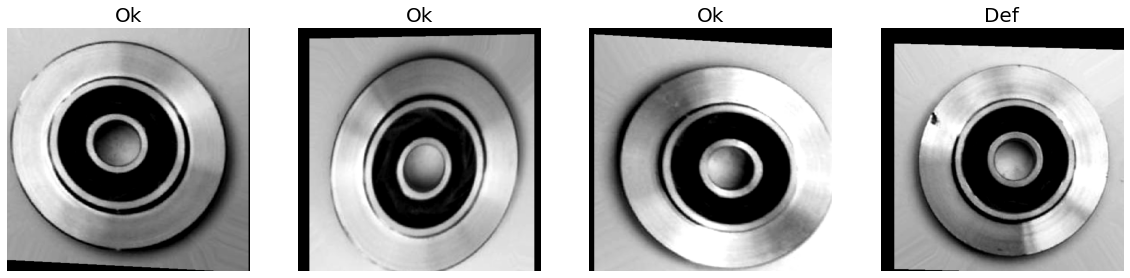

In [ ]:
index = 1
nr_batch = 11
plt.figure(figsize=(20, 20))
for nr_img in range(train_batch_size):
    plt.subplot(1, train_batch_size, index)
    if train_gen[nr_batch][1][nr_img] == 1.0:
        title = 'Ok'
    else:
        title = 'Def'
    plt.title(title, fontsize=20)
    plt.imshow(train_gen[nr_batch][0][nr_img]/255)
    plt.axis('off')
    index +=1

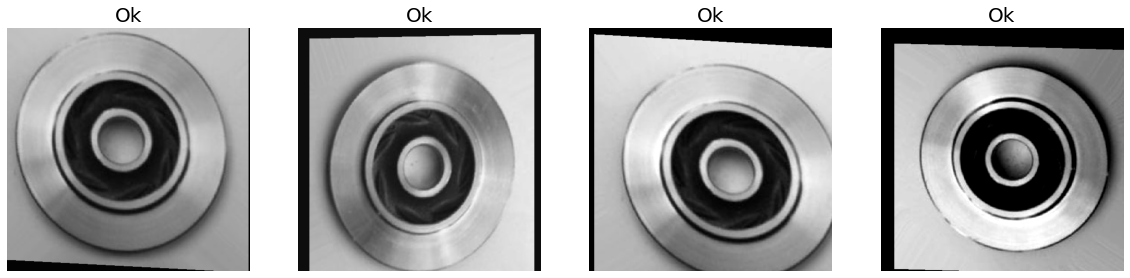

In [ ]:
index = 1
nr_batch = 11
plt.figure(figsize=(20, 20))
for nr_img in range(train_batch_size):
    plt.subplot(1, train_batch_size, index)
    if val_gen[nr_batch][1][nr_img] == 1.0:
        title = 'Ok'
    else:
        title = 'Def'
    plt.title(title, fontsize=20)
    plt.imshow(val_gen[nr_batch][0][nr_img]/255)
    plt.axis('off')
    index +=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


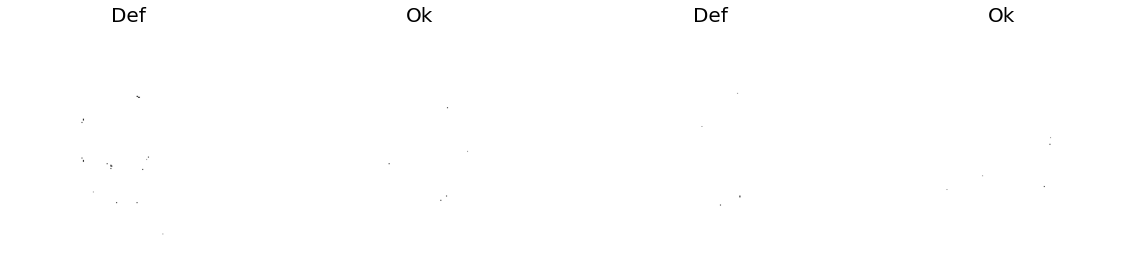

In [ ]:
index = 1
plt.figure(figsize=(20, 20))
for nr_batch in range(train_batch_size):
    plt.subplot(1, train_batch_size, index)
    if test_gen[nr_batch][1][0] == 1.0:
        title = 'Ok'
    else:
        title = 'Def'
    plt.title(title, fontsize=20)
    plt.imshow(test_gen[nr_batch][0][0])
    plt.axis('off')
    index +=1

## Declare Model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4 as EffNet

In [ ]:
%%time 

input_shape = (input_height, input_width, 3)
base_model = EffNet(
    include_top=False,
    input_shape=input_shape,
    weights="imagenet"
)

In [ ]:
def get_model():
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

## Training

In [ ]:
# n_epochs = 10
# train_batch_size = 4
# validation_split = 0.2

In [ ]:
tf.random.set_seed(404)
train_gen = imageGenerator.flow_from_directory(
    train_path,
    target_size=(input_height, input_width),
    classes=["def_front", "ok_front"],
    class_mode="binary",
    batch_size=train_batch_size,
    subset="training",
    seed=404
)

val_gen = imageGenerator.flow_from_directory(
    train_path,
    target_size=(input_height, input_width),
    classes=["def_front", "ok_front"],
    class_mode="binary",
    batch_size=train_batch_size,
    subset="validation",
    seed=404
)

test_gen = ImageDataGenerator(dtype=tf.float32, preprocessing_function=backbone.preprocess_input).flow_from_directory(
    test_path,
    target_size=(input_height, input_width),
    classes=["def_front", "ok_front"],
    class_mode="binary",
    batch_size=1,
    seed=404
)

validation_steps = len(val_gen) // train_batch_size
steps_per_epoch = len(train_gen) // train_batch_size

tf.keras.backend.clear_session() # clear all model(เพิ่ม memory space ที่เหลือ)
model = get_model()
model.summary()

model.compile(
#     optimizer=tf.keras.optimizers.SGD(learning_rate=scheduler, momentum=0.9, nesterov=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=n_epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    # callbacks=[get_TensorBoard(myfile)]
)

In [ ]:
loss, accuracy = model.evaluate(test_gen)
print(f"Loss :{loss:.4f} Accuracy:{accuracy*100:.4f}%")

# Evaluate

In [ ]:
y_true, y_score = [], []
for i, (x, y) in tqdm(enumerate(test_gen), total=len(test_gen)):
    y_true.append(y[0])
    y_score.append(model(x, training=False)[0][0].numpy())
    if i+1 > len(test_gen):
        break
y_true = np.array(y_true)
y_score = np.array(y_score)

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
thresh = 0.1
y_pred = np.array([1. if yi > thresh else 0. for yi in y_score])

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
sns.heatmap(cm / np.sum(cm, axis=0), annot=True, ax=ax[1])
ax[0].set_title("Confusion Matrix")
ax[1].set_title("Normalized Confusion Matrix")
plt.show()
print(f"Threshold = {thresh}")
print(f"Accuracy: {acc*100:.2f}%\nRecall: {recall*100:.2f}%\nF1-score: {f1:.2f}")

In [ ]:
thresh = 0.2
y_pred = np.array([1. if yi > thresh else 0. for yi in y_score])

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
sns.heatmap(cm / np.sum(cm, axis=0), annot=True, ax=ax[1])
ax[0].set_title("Confusion Matrix")
ax[1].set_title("Normalized Confusion Matrix")
plt.show()
print(f"Threshold = {thresh}")
print(f"Accuracy: {acc*100:.2f}%\nRecall: {recall*100:.2f}%\nF1-score: {f1:.2f}")

In [ ]:
thresh = 0.3
y_pred = np.array([1. if yi > thresh else 0. for yi in y_score])

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
sns.heatmap(cm / np.sum(cm, axis=0), annot=True, ax=ax[1])
ax[0].set_title("Confusion Matrix")
ax[1].set_title("Normalized Confusion Matrix")
plt.show()
print(f"Threshold = {thresh}")
print(f"Accuracy: {acc*100:.2f}%\nRecall: {recall*100:.2f}%\nF1-score: {f1:.2f}")

In [ ]:
thresh = 0.4
y_pred = np.array([1. if yi > thresh else 0. for yi in y_score])

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
sns.heatmap(cm / np.sum(cm, axis=0), annot=True, ax=ax[1])
ax[0].set_title("Confusion Matrix")
ax[1].set_title("Normalized Confusion Matrix")
plt.show()
print(f"Threshold = {thresh}")
print(f"Accuracy: {acc*100:.2f}%\nRecall: {recall*100:.2f}%\nF1-score: {f1:.2f}")

In [ ]:
thresh = 0.5
y_pred = np.array([1. if yi > thresh else 0. for yi in y_score])

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
sns.heatmap(cm / np.sum(cm, axis=0), annot=True, ax=ax[1])
ax[0].set_title("Confusion Matrix")
ax[1].set_title("Normalized Confusion Matrix")
plt.show()
print(f"Threshold = {thresh}")
print(f"Accuracy: {acc*100:.2f}%\nRecall: {recall*100:.2f}%\nF1-score: {f1:.2f}")